# DEEP ENSAMBLES

In [61]:
# Cell 1: imports & config
import math, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from mnist_utils import MLP  # or define/import your MLP here
import importlib
import utils
from pathlib import Path

device = torch.device("cpu")   # per your setup
ENSEMBLE_SIZE = 30
EPOCHS = 30                     # adjust up (e.g., 12–20) for best accuracy
BATCH_SIZE = 256               # use what you used before
LR = 1e-3
WEIGHT_DECAY = 1e-4
DROPOUT_P = 0.2                # dropout inside members; 0 is fine for ensembles
BASE_SEED = 2025               # any integer
SAVE_DIR = "checkpoints_ensemble"


In [31]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True) # change to 128 to make loss smoother.
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

In [32]:
# Cell 2: utilities
import os
from torch.utils.data import DataLoader, RandomSampler

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# def make_train_loader(base_dataset, batch_size=128, seed=0):
#     """
#     Returns a DataLoader for one ensemble member.
#     - If bootstrap=False: standard shuffle=True
#     - If bootstrap=True: RandomSampler with replacement (bagging)
#     """
#     set_seed(seed)
#     loader = DataLoader(base_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
#     return loader


In [33]:
# Cell 3: single-model training loop
def train_one_member(member_id: int,
                     data_loader,
                     epochs=EPOCHS,
                     lr=LR,
                     wd=WEIGHT_DECAY,
                     dropout=DROPOUT_P,
                     save_dir=SAVE_DIR):
    seed = BASE_SEED + member_id
    set_seed(seed)

    # model + optimizer
    model = MLP(n_hidden=128, n_labels=10, width=28, length=28, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # loader (same dataset; optionally bootstrapped for more diversity)
    set_seed(seed)
    model.train()
    for ep in range(1, epochs + 1):
        running = 0.0
        n = 0
        for xb, yb in data_loader:
            optimizer.zero_grad()

            logits, loss = model(xb, yb)
            loss.backward()
            optimizer.step()

            running += loss.item() * xb.size(0)
            n += xb.size(0)

        print(f"[member {member_id:02d}] epoch {ep:02d}/{epochs} loss {running/n:.4f}")

    # save weights
    os.makedirs(save_dir, exist_ok=True)
    path = os.path.join(save_dir, f"mlp_member_{member_id:02d}.pth")
    torch.save({"state_dict": model.state_dict(),
                "config": {"n_hidden": 128, "n_labels": 10, "width": 28, "length": 28, "dropout": dropout}},
               path)
    return model


In [41]:
# DO NOT RUN THIS CELL - load the checkpoints instead
# Cell 4: train the whole ensemble 
# Assumes you already have `train_loader` and `test_loader`.
# We only need the dataset object for constructing per-member loaders.

ensemble = []
start = time.time()
for m in range(ENSEMBLE_SIZE):
    model_m = train_one_member(m, train_loader)  
    ensemble.append(model_m)
print(f"Trained {len(ensemble)} members in {time.time()-start:.1f}s")


[member 00] epoch 01/30 loss 0.4385
[member 00] epoch 02/30 loss 0.2290
[member 00] epoch 03/30 loss 0.1875
[member 00] epoch 04/30 loss 0.1671
[member 00] epoch 05/30 loss 0.1522
[member 00] epoch 06/30 loss 0.1413
[member 00] epoch 07/30 loss 0.1375
[member 00] epoch 08/30 loss 0.1287
[member 00] epoch 09/30 loss 0.1240
[member 00] epoch 10/30 loss 0.1201
[member 00] epoch 11/30 loss 0.1168
[member 00] epoch 12/30 loss 0.1126
[member 00] epoch 13/30 loss 0.1086
[member 00] epoch 14/30 loss 0.1077
[member 00] epoch 15/30 loss 0.1072
[member 00] epoch 16/30 loss 0.1015
[member 00] epoch 17/30 loss 0.1022
[member 00] epoch 18/30 loss 0.0998
[member 00] epoch 19/30 loss 0.1022
[member 00] epoch 20/30 loss 0.0995
[member 00] epoch 21/30 loss 0.0953
[member 00] epoch 22/30 loss 0.0972
[member 00] epoch 23/30 loss 0.0949
[member 00] epoch 24/30 loss 0.0935
[member 00] epoch 25/30 loss 0.0924
[member 00] epoch 26/30 loss 0.0892
[member 00] epoch 27/30 loss 0.0901
[member 00] epoch 28/30 loss

In [42]:
# DO NOT RUN THIS CELL
# Cell 5: save all weights
import os
os.makedirs(SAVE_DIR, exist_ok=True)
for i, m in enumerate(ensemble):
    torch.save(m.state_dict(), os.path.join(SAVE_DIR, f"member_{i:02d}.pth"))


In [45]:
loaded_ensemble = []
for i in range(ENSEMBLE_SIZE):
    model = MLP(n_hidden=128, dropout=DROPOUT_P)
    state = torch.load(os.path.join(SAVE_DIR, f"member_{i:02d}.pth"), map_location="cpu")
    model.load_state_dict(state)  # <-- state is a pure state_dict
    model.eval()
    loaded_ensemble.append(model)


In [44]:
# Cell 6: load models - you can load these immediately
loaded_ensemble = []
for i in range(ENSEMBLE_SIZE):
    model = MLP(n_hidden=128, dropout=DROPOUT_P)
    state = torch.load(os.path.join(SAVE_DIR, f"member_{i:02d}.pth"), map_location="cpu")
    model.load_state_dict(state)
    model.eval()
    loaded_ensemble.append(model)


In [ ]:
# Evaluate on the held-out  test split
# vanilla MLP - 'accuracy': 0.9786434173583984,
# 'f1_macro': 0.9786311984062195,
importlib.reload(utils) 
from utils import evaluate_ensemble

metrics = evaluate_ensemble(
    split="test",
    models=loaded_ensemble,
    train_loader=train_loader,
    test_loader=test_loader,
    num_classes=10,
    scaler=None,   # or None
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    weights=None,               # or e.g., [1,1,1,1,1]
    combine="logits"            # or "probs"
)
print(metrics["accuracy"], metrics["f1_macro"])


0.9835065603256226 0.9835870862007141


In [56]:
# let's now see how has this changed our original predictions, did it imporve base metrics - 
from utils import collect_ensemble_misclassified, show_misclassified
records = collect_ensemble_misclassified(ensemble, test_loader, device=device)
#show_misclassified(records, n=20, sort="confidence", largest=False)


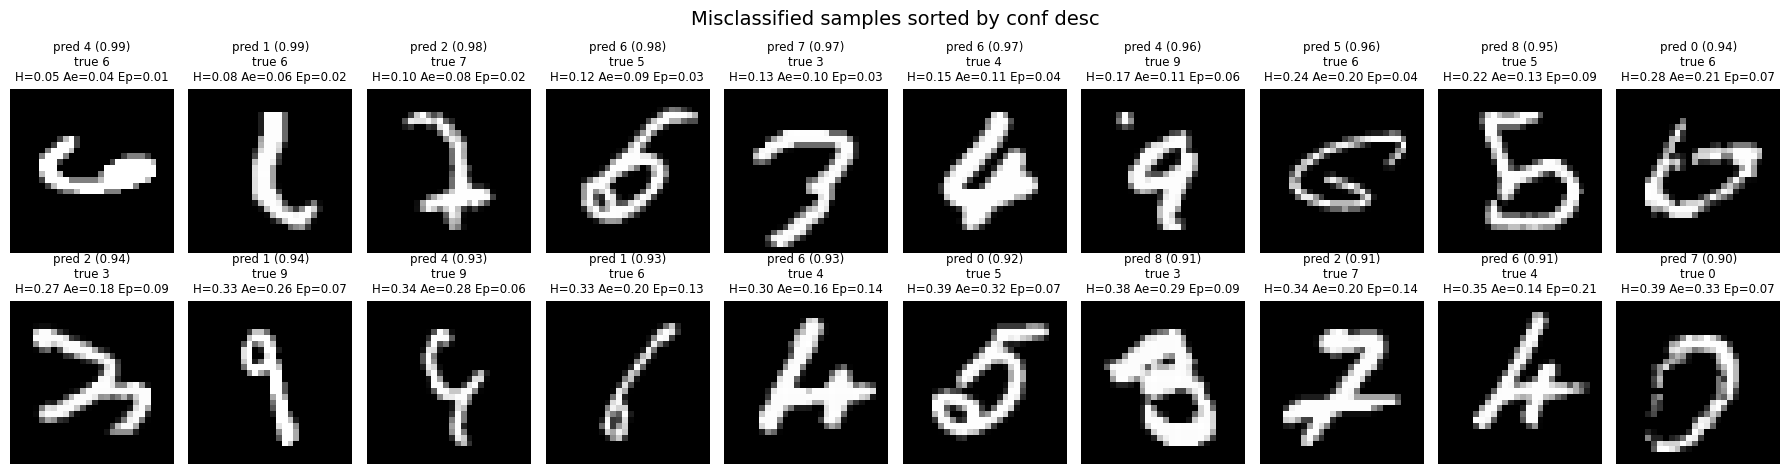

In [58]:
importlib.reload(utils) 
from utils import plot_ensemble_misclassified_with_uncertainty
plot_ensemble_misclassified_with_uncertainty(
    ensemble, test_loader, n=20, cols=10, device=device,
    denorm=True, mean=0.1307, std=0.3081, sort_by="conf_desc"
)

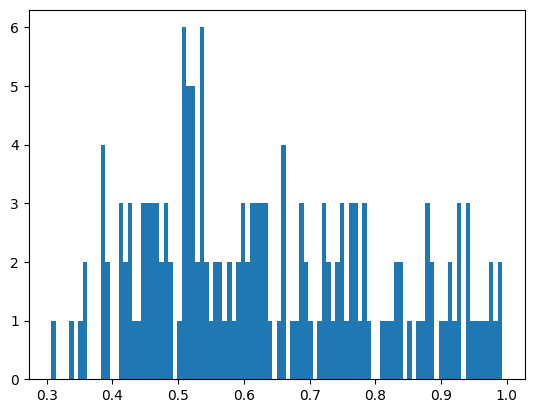

In [59]:
# plot confidences of misclassified images
plt.hist([records[i]['conf'] for i in range(len(records))], bins=100);

In [13]:
# individual uncertainty of a prediction

def compute_uncertainties(ensemble_models, x):
    ensemble_models = [model.eval().to(device) for model in ensemble_models]

    with torch.no_grad():
        preds = [F.softmax(model(x)[0], dim=1) for model in ensemble_models]  # list of [batch, C]
        preds = torch.stack(preds)  # [M, batch, C]

        mean_preds = preds.mean(dim=0)  # [batch, C]

        # Total uncertainty (entropy of mean prediction)
        total_uncertainty = -torch.sum(mean_preds * mean_preds.log(), dim=1)

        # Aleatoric uncertainty (mean entropy of predictions)
        aleatoric_uncertainty = -torch.mean(torch.sum(preds * preds.log(), dim=2), dim=0)

        # Epistemic = Total - Aleatoric
        epistemic_uncertainty = total_uncertainty - aleatoric_uncertainty

    return total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty


In [19]:
math.log(10)

2.302585092994046

# OOD data

In [62]:
# --- Load saved OOD datasets and create DataLoaders ---

importlib.reload(utils) 
from utils import OODDataset



# Your transform (same style as MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# --- Choose what you want to load ---
root = Path("./data/ood")

# 1) Separate datasets + loaders
ds_gauss   = OODDataset(root / "ood_gaussian.pt",          transform=transform)
ds_lines   = OODDataset(root / "ood_horizontal_lines.pt",  transform=transform)
ds_spiral  = OODDataset(root / "ood_spiral.pt",            transform=transform)
ds_checker = OODDataset(root / "ood_checkerboard.pt",      transform=transform)

loader_gauss   = DataLoader(ds_gauss,   batch_size=64, shuffle=False)
loader_lines   = DataLoader(ds_lines,   batch_size=64, shuffle=False)
loader_spiral  = DataLoader(ds_spiral,  batch_size=64, shuffle=False)
loader_checker = DataLoader(ds_checker, batch_size=64, shuffle=False)


In [71]:
importlib.reload(utils) 
from utils import plot_ood_uncertainties_ensemble

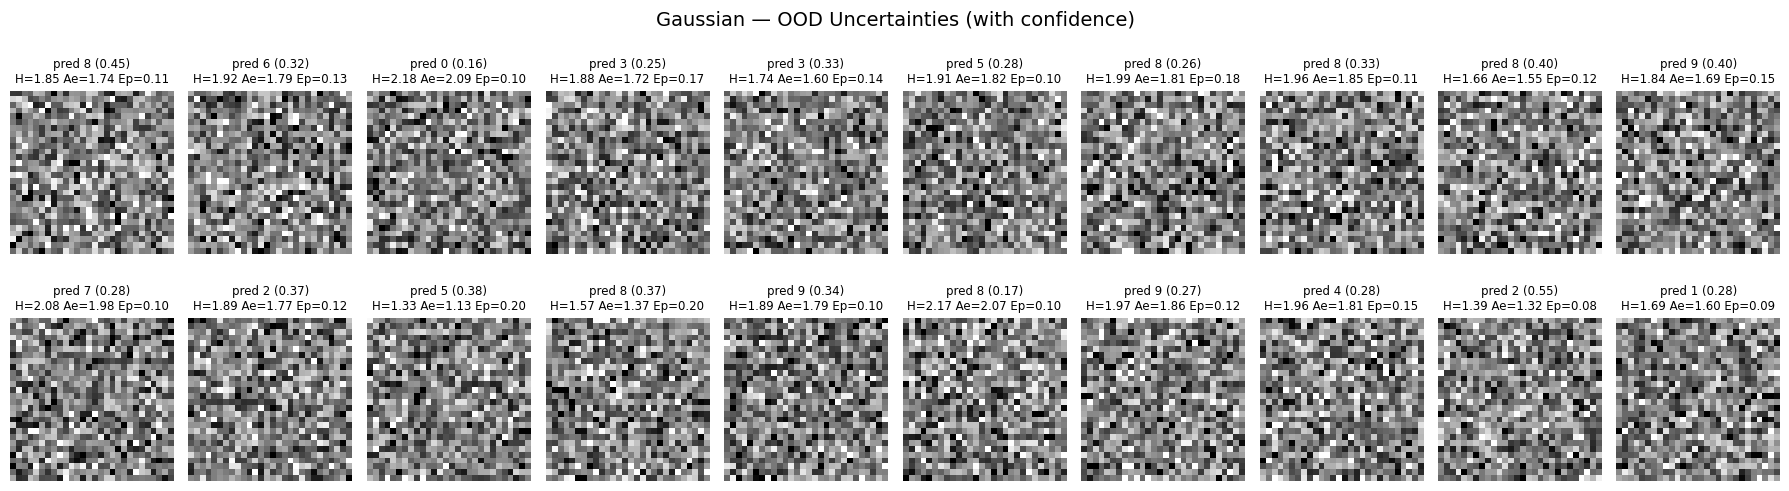

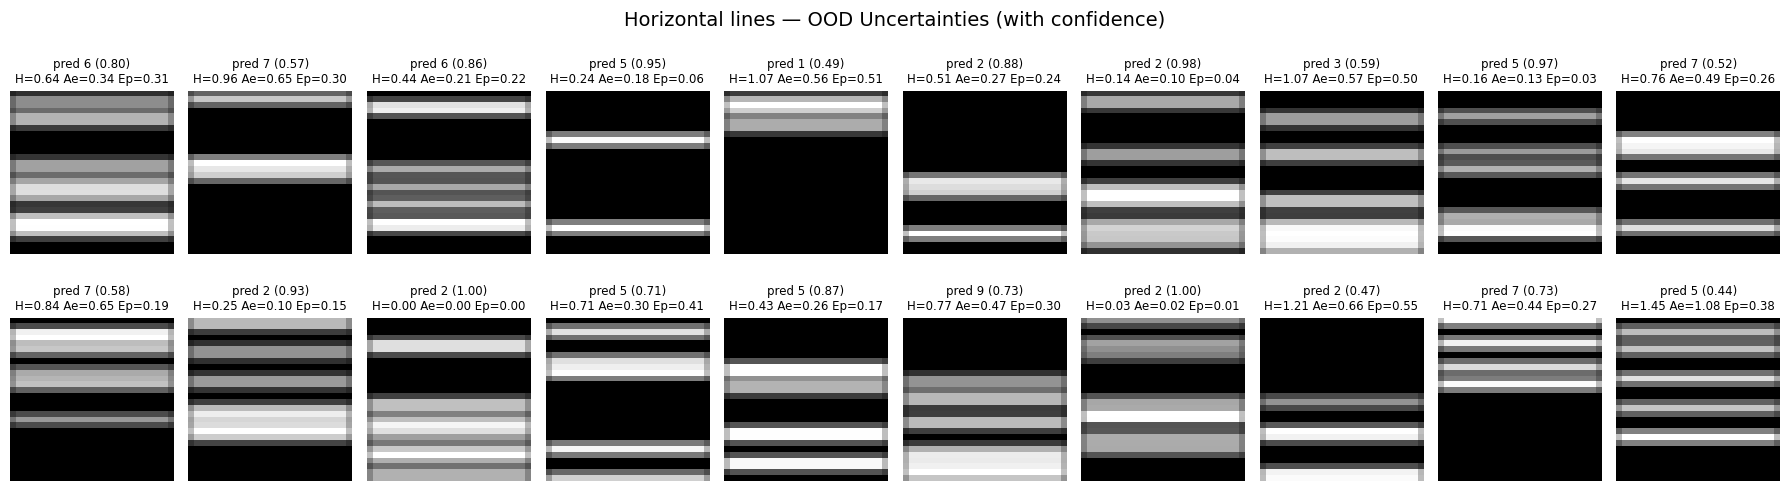

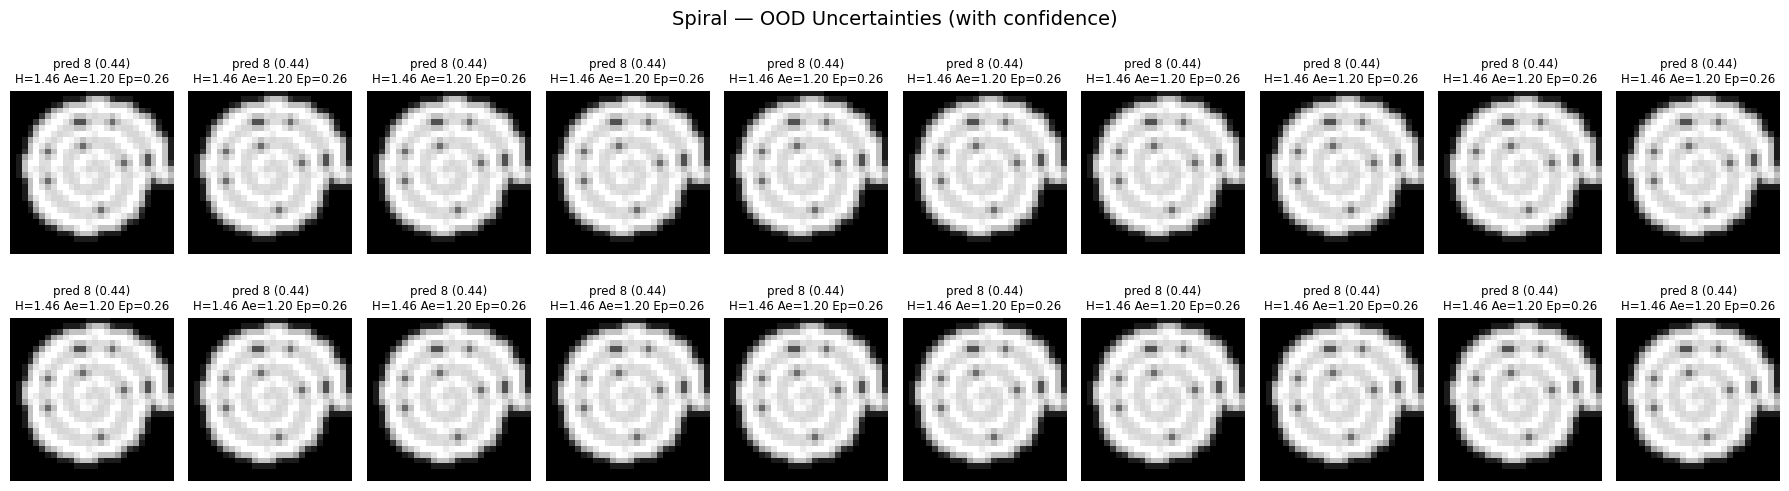

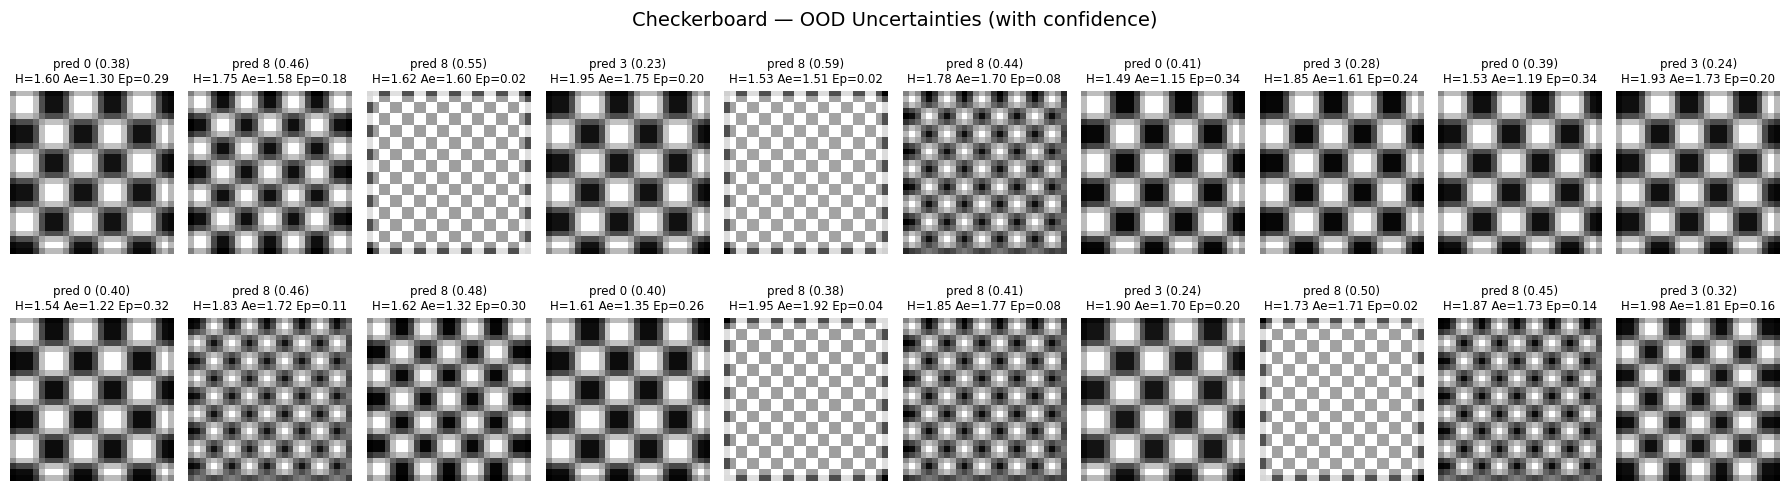

In [72]:
ood_loaders = [loader_gauss, loader_lines, loader_spiral, loader_checker]
names       = ["Gaussian", "Horizontal lines", "Spiral", "Checkerboard"]

plot_ood_uncertainties_ensemble(
    ensemble=loaded_ensemble,
    ood_loaders=ood_loaders,
    names=names,
    n=20,
    cols=10,
    device="cuda" if torch.cuda.is_available() else "cpu",
    denorm=True,
    mean=0.5, std=0.5,           # matches your OOD transform
    scaler=None     # or None
)


In [75]:
# calculate mean UQ helper for any loader (no labels needed) ---


@torch.inference_mode()
def ensemble_uq_on_loader(ensemble, loader, device="cpu", eps=1e-12):
    """
    Returns dict with per-sample tensors:
      p_hat [N,C], conf [N], H_pred [N], H_exp [N], MI [N], y_pred [N]
    and summary stats.
    """
    # move members once
    for m in ensemble:
        m.to(device).eval()

    member_batches = []   # will be concatenated to [M, N, C]
    N_total = 0
    for xb, _ in loader:
        xb = xb.to(device)
        probs_m = []
        for model in ensemble:
            out = model(xb)
            logits = out[0] if isinstance(out, (tuple, list)) else out
            probs_m.append(torch.softmax(logits, dim=1).cpu())  # [B,C]
        member_batches.append(torch.stack(probs_m, dim=0))       # [M,B,C]
        N_total += xb.size(0)

    probs_all = torch.cat(member_batches, dim=1)   # [M,N,C]
    p_hat = probs_all.mean(dim=0)                  # [N,C]
    conf, y_pred = p_hat.max(dim=1)                # [N], [N]

    def entropy(p):
        p = p.clamp_min(eps)
        return -(p * p.log()).sum(dim=-1)

    H_pred = entropy(p_hat)                        # predictive entropy
    H_exp  = entropy(probs_all).mean(dim=0)        # expected entropy across members
    MI     = H_pred - H_exp                        # epistemic (mutual information)

    summary = {
        "N": N_total,
        "conf_mean": conf.mean().item(),
        "conf_95p":  conf.quantile(0.95).item(),
        "H_mean":    H_pred.mean().item(),
        "MI_mean":   MI.mean().item(),
    }
    out = {"p_hat": p_hat, "y_pred": y_pred, "confidence": conf,
           "H_pred": H_pred, "H_exp": H_exp, "MI": MI}
    return summary, out


In [79]:
# --- Cell: compute OOD uncertainties with the ensemble ---

sum_g, out_g = ensemble_uq_on_loader(ensemble, loader_gauss,  device=device)
sum_l, out_l = ensemble_uq_on_loader(ensemble, loader_lines,  device=device)
sum_s, out_s = ensemble_uq_on_loader(ensemble, loader_spiral, device=device)
sum_c, out_c = ensemble_uq_on_loader(ensemble, loader_checker, device=device)


print("Gaussian:",         sum_g)
print("Horizontal lines:", sum_l)
print("Spiral:",           sum_s)
print("Checkerboard:",           sum_c)


Gaussian: {'N': 1000, 'conf_mean': 0.3826684355735779, 'conf_95p': 0.681870698928833, 'H_mean': 1.7186311483383179, 'MI_mean': 0.13076043128967285}
Horizontal lines: {'N': 1000, 'conf_mean': 0.7241141200065613, 'conf_95p': 0.9966616630554199, 'H_mean': 0.7132325768470764, 'MI_mean': 0.27663010358810425}
Spiral: {'N': 1000, 'conf_mean': 0.43905603885650635, 'conf_95p': 0.4390561282634735, 'H_mean': 1.464362382888794, 'MI_mean': 0.26355546712875366}
Checkerboard: {'N': 1000, 'conf_mean': 0.417263925075531, 'conf_95p': 0.5961032509803772, 'H_mean': 1.7743210792541504, 'MI_mean': 0.13849259912967682}


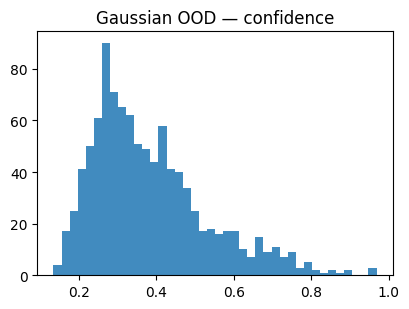

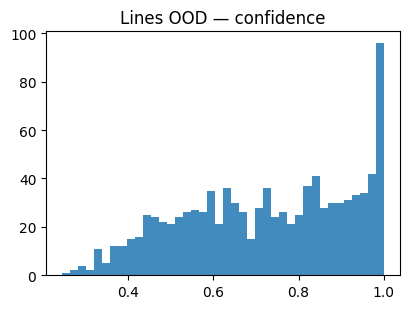

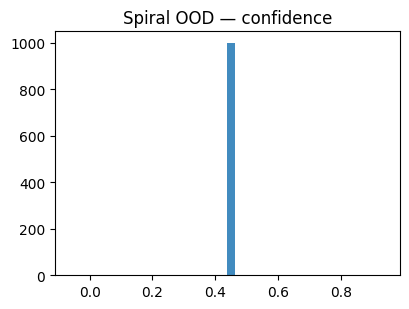

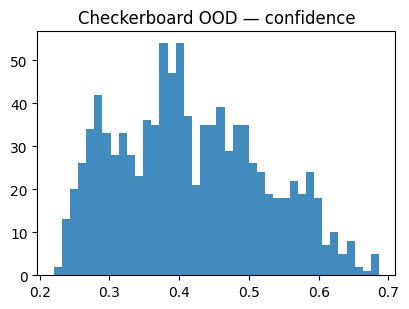

In [81]:
# --- Cell: visualize uncertainty histograms for each OOD kind ---

def plot_hist(vec, title, bins=40):
    vec = vec.cpu().numpy()
    plt.figure(figsize=(4.2,3.2))
    plt.hist(vec, bins=bins, alpha=0.85)
    plt.title(title); plt.tight_layout(); plt.show()

plot_hist(out_g["confidence"], "Gaussian OOD — confidence")


plot_hist(out_l["confidence"], "Lines OOD — confidence")


plot_hist(out_s["confidence"], "Spiral OOD — confidence")

plot_hist(out_c["confidence"], "Checkerboard OOD — confidence")


